# load af Dataset og grundfunktioner

In [1]:
%%capture
!pip install datasets
!pip install bpemb

In [2]:
from torch.utils.data import DataLoader, Dataset
import nltk
from bpemb import BPEmb
import string
from datasets import load_dataset
from tqdm import tqdm
import numpy as np
from torch import nn
import torch

In [3]:
dataset = load_dataset("copenlu/answerable_tydiqa")
nltk.download('punkt')

#train_set = dataset["train"]
#validation_set = dataset["validation"]

def get_answer_start(row):
  return row["annotations"]["answer_start"][0]

def get_answer(row):
  return row["annotations"]["answer_text"][0]

def get_document(row):
  return row["document_plaintext"]

def get_question(row):
  return row["question_text"]

def oracle(answer, document):
  return answer != "" and answer in document

def get_language(dataset, lang):
  return dataset.filter(lambda x: x["language"] == lang)#[row for row in dataset if row['language'] == lang]

def get_answerble(dataset):
  return dataset.filter(lambda x: x["annotations"]["answer_start"] != [-1])


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/116067 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13325 [00:00<?, ? examples/s]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
def add_index(examples, idx):
    # Adding an 'id' field with the index value
    examples["id"] = idx
    return examples

In [5]:
dataset_idx = dataset.map(add_index, with_indices=True)

Map:   0%|          | 0/116067 [00:00<?, ? examples/s]

Map:   0%|          | 0/13325 [00:00<?, ? examples/s]

In [ ]:
print(dataset_idx['train'][0])
print(dataset_idx['validation'][0])

{'question_text': 'Milloin Charles Fort syntyi?', 'document_title': 'Charles Fort', 'language': 'finnish', 'annotations': {'answer_start': [18], 'answer_text': ['6. elokuuta (joidenkin lähteiden mukaan 9.) 1874']}, 'document_plaintext': 'Charles Hoy Fort (6. elokuuta (joidenkin lähteiden mukaan 9.) 1874 – 3. toukokuuta 1932) oli yhdysvaltalainen kirjailija ja paranormaalien ilmiöiden tutkija.', 'document_url': 'https://fi.wikipedia.org/wiki/Charles%20Fort', 'id': 0}
{'question_text': 'อยุธยามีกี่อำเภอ ?', 'document_title': 'จังหวัดพระนครศรีอยุธยา', 'language': 'thai', 'annotations': {'answer_start': [42], 'answer_text': ['16']}, 'document_plaintext': '\nปัจจุบันจังหวัดพระนครศรีอยุธยาประกอบด้วย 16 อำเภอ ได้แก่', 'document_url': 'https://th.wikipedia.org/wiki/%E0%B8%88%E0%B8%B1%E0%B8%87%E0%B8%AB%E0%B8%A7%E0%B8%B1%E0%B8%94%E0%B8%9E%E0%B8%A3%E0%B8%B0%E0%B8%99%E0%B8%84%E0%B8%A3%E0%B8%A8%E0%B8%A3%E0%B8%B5%E0%B8%AD%E0%B8%A2%E0%B8%B8%E0%B8%98%E0%B8%A2%E0%B8%B2', 'id': 0}


In [6]:
train_set=dataset_idx['train']
validation_set=dataset_idx['validation']

In [7]:
vocab_size = 25000
encoding_dim = 100

bpemb_ar = BPEmb(lang='ar', dim=encoding_dim, vs=vocab_size)
bpemb_bn = BPEmb(lang='bn', dim=encoding_dim, vs=vocab_size)
bpemb_in = BPEmb(lang='id', dim=encoding_dim, vs=vocab_size)
bpemb_en = BPEmb(lang='en', dim=encoding_dim, vs=vocab_size)

downloading https://nlp.h-its.org/bpemb/ar/ar.wiki.bpe.vs25000.model


100%|██████████| 742254/742254 [00:01<00:00, 721905.79B/s]


downloading https://nlp.h-its.org/bpemb/ar/ar.wiki.bpe.vs25000.d100.w2v.bin.tar.gz


100%|██████████| 9491724/9491724 [00:02<00:00, 4557362.34B/s]


downloading https://nlp.h-its.org/bpemb/bn/bn.wiki.bpe.vs25000.model


100%|██████████| 863227/863227 [00:01<00:00, 698298.62B/s]


downloading https://nlp.h-its.org/bpemb/bn/bn.wiki.bpe.vs25000.d100.w2v.bin.tar.gz


100%|██████████| 9517491/9517491 [00:02<00:00, 4284407.41B/s]


downloading https://nlp.h-its.org/bpemb/id/id.wiki.bpe.vs25000.model


100%|██████████| 650018/650018 [00:01<00:00, 648262.07B/s]


downloading https://nlp.h-its.org/bpemb/id/id.wiki.bpe.vs25000.d100.w2v.bin.tar.gz


100%|██████████| 9465922/9465922 [00:02<00:00, 4540210.35B/s]


downloading https://nlp.h-its.org/bpemb/en/en.wiki.bpe.vs25000.model


100%|██████████| 661443/661443 [00:01<00:00, 644958.84B/s]


downloading https://nlp.h-its.org/bpemb/en/en.wiki.bpe.vs25000.d100.w2v.bin.tar.gz


100%|██████████| 9477142/9477142 [00:02<00:00, 4258320.74B/s]


### English

In [ ]:
train_english = get_language(train_set, "english")
val_english = get_language(validation_set, "english")

Filter:   0%|          | 0/116067 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13325 [00:00<?, ? examples/s]

In [ ]:
train_english_answerble = get_answerble(train_english)
validation_english_answerble = get_answerble(val_english)

Filter:   0%|          | 0/7389 [00:00<?, ? examples/s]

In [ ]:
train_english_answerble

Dataset({
    features: ['question_text', 'document_title', 'language', 'annotations', 'document_plaintext', 'document_url', 'id'],
    num_rows: 3696
})

In [ ]:
train_english_tt = train_english_answerble.train_test_split(test_size=0.2)

In [ ]:
train_english_tt['test']

Dataset({
    features: ['question_text', 'document_title', 'language', 'annotations', 'document_plaintext', 'document_url', 'id'],
    num_rows: 740
})

### language data

In [8]:
train_arabic = get_language(train_set, "arabic")
val_arabic = get_language(validation_set, "arabic")

train_bengali = get_language(train_set, "bengali")
val_bengali = get_language(validation_set, "bengali")

train_indonesian = get_language(train_set, "indonesian")
val_indonesian = get_language(validation_set, "indonesian")

Filter:   0%|          | 0/116067 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13325 [00:00<?, ? examples/s]

Filter:   0%|          | 0/116067 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13325 [00:00<?, ? examples/s]

Filter:   0%|          | 0/116067 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13325 [00:00<?, ? examples/s]

In [9]:
train_arabic_answerble = get_answerble(train_arabic)
val_arabic_answerble = get_answerble(val_arabic)

train_bengali_answerble = get_answerble(train_bengali)
val_bengali_answerble = get_answerble(val_bengali)

train_indonesian_answerble = get_answerble(train_indonesian)
val_indonesian_answerble = get_answerble(val_indonesian)

Filter:   0%|          | 0/29598 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1902 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4779 [00:00<?, ? examples/s]

Filter:   0%|          | 0/224 [00:00<?, ? examples/s]

Filter:   0%|          | 0/11394 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1191 [00:00<?, ? examples/s]

In [10]:
train_arabic_tt = train_arabic_answerble.train_test_split(test_size=0.2)
train_bengali_tt = train_bengali_answerble.train_test_split(test_size=0.2)
train_indonesian_tt = train_indonesian_answerble.train_test_split(test_size=0.2)

#Roberta

In [11]:
device = torch.device("cpu")
if torch.cuda.is_available():
  device = torch.device("cuda")


In [12]:
!pip install update transformers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 34.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 30.2 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.18.0
    Uninstalling huggingface-hub-0.18.0:
      Successfully uninstalled huggingface-hub-0.18.0


In [13]:
from datasets import load_dataset
from datasets import load_metric
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
from transformers import AutoModelForQuestionAnswering
from transformers import AutoConfig
from functools import partial
import torch
import random
import numpy as np
from tqdm import tqdm
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
from torch.optim.lr_scheduler import LambdaLR
from torch import nn
from collections import defaultdict, OrderedDict
MODEL_NAME = 'xlm-roberta-base'
#MODEL_NAME = 'bert-base-uncased'

In [14]:
""" Official evaluation script for v1.1 of the SQuAD dataset. """
from __future__ import print_function
from collections import Counter
import string
import re
import argparse
import json
import sys


def normalize_answer(s):
    """Lower text and remove punctuation, articles and extra whitespace."""
    def remove_articles(text):
        return re.sub(r'\b(a|an|the)\b', ' ', text)

    def white_space_fix(text):
        return ' '.join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))


def f1_score(prediction, ground_truth):
    prediction_tokens = normalize_answer(prediction).split()
    ground_truth_tokens = normalize_answer(ground_truth).split()
    common = Counter(prediction_tokens) & Counter(ground_truth_tokens)
    num_same = sum(common.values())
    if num_same == 0:
        return 0
    precision = 1.0 * num_same / len(prediction_tokens)
    recall = 1.0 * num_same / len(ground_truth_tokens)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1


def exact_match_score(prediction, ground_truth):
    return (normalize_answer(prediction) == normalize_answer(ground_truth))


def metric_max_over_ground_truths(metric_fn, prediction, ground_truths):
    scores_for_ground_truths = []
    for ground_truth in ground_truths:
        score = metric_fn(prediction, ground_truth)
        scores_for_ground_truths.append(score)
    return max(scores_for_ground_truths)


def evaluate_squad(dataset, predictions):
    f1 = exact_match = total = 0
    for article in dataset:
        for paragraph in article['paragraphs']:
            for qa in paragraph['qas']:
                total += 1
                if qa['id'] not in predictions:
                    message = 'Unanswered question ' + qa['id'] + \
                              ' will receive score 0.'
                    print(message, file=sys.stderr)
                    continue
                ground_truths = list(map(lambda x: x['text'], qa['answers']))
                prediction = predictions[qa['id']]
                exact_match += metric_max_over_ground_truths(
                    exact_match_score, prediction, ground_truths)
                f1 += metric_max_over_ground_truths(
                    f1_score, prediction, ground_truths)

    exact_match = 100.0 * exact_match / total
    f1 = 100.0 * f1 / total

    return {'exact_match': exact_match, 'f1': f1}

def compute_squad(predictions, references):
  pred_dict = {prediction["id"]: prediction["prediction_text"] for prediction in predictions}
  dataset = [
      {
          "paragraphs": [
              {
                  "qas": [
                      {
                          "answers": [{"text": answer_text} for answer_text in ref["answers"]["answer_text"]],
                          "id": ref["id"],
                      }
                      for ref in references
                  ]
              }
          ]
      }
  ]
  score = evaluate_squad(dataset=dataset, predictions=pred_dict)
  return score

In [15]:
# this is also equivalent to those 2 lines. I recommend going with that, unless you want more control over your code
from datasets import load_metric
compute_squad = load_metric("squad_v2")

<ipython-input-15-263c584f0d34>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  compute_squad = load_metric("squad_v2")


# validate and predict

In [16]:
def get_validation_features(tk, samples):
  # First, tokenize the text. We get the offsets and return overflowing sequences in
  # order to break up long sequences into multiple inputs. The offsets will help us
  # determine the original answer text
  batch = tk.batch_encode_plus(
        [[q,c] for q,c in zip(samples['question_text'], samples['document_plaintext'])],
        padding='max_length',
        truncation='only_second',
        stride=128,
        return_overflowing_tokens=True,
        return_offsets_mapping=True
    )

  # We'll store the ID of the samples to calculate squad score
  batch['example_id'] = []
  # The overflow sample map tells us which input each sample corresponds to
  sample_map = batch.pop('overflow_to_sample_mapping')

  for i in range(len(batch['input_ids'])):
    # The sample index tells us which of the values in "samples" these features belong to
    sample_idx = sample_map[i]
    sequence_ids = batch.sequence_ids(i)

    # Add the ID to map these features back to the correct sample
    batch['example_id'].append(samples['id'][sample_idx])

    #Set offsets for non-context words to be None for ease of processing
    batch['offset_mapping'][i] = [o if sequence_ids[k] == 1 else None for k,o in enumerate(batch['offset_mapping'][i])]

  return batch

def val_collate_fn(inputs):
  input_ids = torch.tensor([i['input_ids'] for i in inputs])
  attention_mask = torch.tensor([i['attention_mask'] for i in inputs])

  # Truncate to max length
  max_len = max(attention_mask.sum(-1))
  input_ids = input_ids[:,:max_len]
  attention_mask = attention_mask[:,:max_len]

  return {'input_ids': input_ids, 'attention_mask': attention_mask}

In [ ]:
def predict(model: nn.Module, valid_dl: DataLoader):
  """
  Evaluates the model on the given dataset
  :param model: The model under evaluation
  :param valid_dl: A `DataLoader` reading validation data
  :return: The accuracy of the model on the dataset
  """
  # VERY IMPORTANT: Put your model in "eval" mode -- this disables things like
  # layer normalization and dropout
  model.eval()
  start_logits_all = []
  end_logits_all = []

  # ALSO IMPORTANT: Don't accumulate gradients during this process
  with torch.no_grad():
    for batch in tqdm(valid_dl, desc='Evaluation'):
      batch = {b: batch[b].to(device) for b in batch}

      # Pass the inputs through the model, get the current loss and logits
      outputs = model(
          input_ids=batch['input_ids'],
          attention_mask=batch['attention_mask']
      )
      # Store the "start" class logits and "end" class logits for every token in the input
      start_logits_all.extend(list(outputs['start_logits'].detach().cpu().numpy()))
      end_logits_all.extend(list(outputs['end_logits'].detach().cpu().numpy()))


    return start_logits_all,end_logits_all

def post_process_predictions(examples, dataset, logits, num_possible_answers = 20, max_answer_length = 30):
  all_start_logits, all_end_logits = logits
  # Build a map from example to its corresponding features. This will allow us to index from
  # sample ID to all of the features for that sample (in case they were split up due to long input)
  example_id_to_index = {k: i for i, k in enumerate(examples["id"])}
  features_per_example = defaultdict(list)
  for i, feature in enumerate(dataset):
      features_per_example[example_id_to_index[feature["example_id"]]].append(i)

  # Create somewhere to store our predictions
  predictions = OrderedDict()

  # Iterate through each sample in the dataset
  for j, sample in enumerate(tqdm(examples)):

    # Get the feature indices (all of the features split across the batch)
    feature_indices = features_per_example[j]
    # Get the original context which predumably has the answer text
    context = sample['document_plaintext']

    preds = []
    # Iterate through all of the features
    for ft_idx in feature_indices:

      # Get the start and end answer logits for this input
      start_logits = all_start_logits[ft_idx]
      end_logits = all_end_logits[ft_idx]

      # Get the offsets to map token indices to character indices
      offset_mapping = dataset[ft_idx]['offset_mapping']

      # Sort the logits and take the top N
      start_indices = np.argsort(start_logits)[::-1][:num_possible_answers]
      end_indices = np.argsort(end_logits)[::-1][:num_possible_answers]

      # Iterate through start and end indices
      for start_index in start_indices:
        for end_index in end_indices:

          # Ignore this combination if either the indices are not in the context
          if start_index >= len(offset_mapping) or end_index >= len(offset_mapping) or offset_mapping[start_index] is None or offset_mapping[end_index] is None:
            continue

          # Also ignore if the start index is greater than the end index of the number of tokens
          # is greater than some specified threshold
          if start_index > end_index or end_index - start_index + 1 > max_answer_length:
            continue

          ans_text = context[offset_mapping[start_index][0]:offset_mapping[end_index][1]]
          preds.append({
              'score': start_logits[start_index] + end_logits[end_index],
              'text': ans_text
          })

    if len(preds) > 0:
      # Sort by score to get the top answer
      answer = sorted(preds, key=lambda x: x['score'], reverse=True)[0]
    else:
      answer = {'score': 0.0, 'text': ""}

    predictions[sample['id']] = answer['text']
  return predictions

# Visualization

In [18]:
import matplotlib.pyplot as plt

def visualize_token2token_scores(scores_mat, tokens, fontproperties = None, x_label_name='Head'):
    fig = plt.figure(figsize=(20, 20))

    for idx, scores in enumerate(scores_mat):
        scores_np = np.array(scores)
        ax = fig.add_subplot(4, 3, idx+1)

        if fontproperties != None:
          for label in ax.get_xticklabels() :
            label.set_fontproperties(fontproperties)

          for label in ax.get_yticklabels() :
            label.set_fontproperties(fontproperties)

        # append the attention weights
        im = ax.imshow(scores, cmap='viridis')

        fontdict = {'fontsize': 10}

        ax.set_xticks(range(len(tokens)))
        ax.set_yticks(range(len(tokens)))

        ax.set_xticklabels(tokens, fontdict=fontdict, rotation=90)
        ax.set_yticklabels(tokens, fontdict=fontdict)
        ax.set_xlabel('{} {}'.format(x_label_name, idx+1))

        fig.colorbar(im, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

def get_min_text(val):

  min_length = 100000
  min_row = {}

  for row in val:
    document = get_document(row)
    question = get_question(row)
    text = question + document

    if len(text) < min_length:
        min_length = len(text)
        min_row = row

  return min_row

## Bengali

In [52]:
from transformers import AutoModel

MODEL_NAME = "simoneZethof/Bengali_multi"

model = AutoModel.from_pretrained(MODEL_NAME, output_attentions=True)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

(…)f/Bengali_multi/resolve/main/config.json:   0%|          | 0.00/716 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Some weights of XLMRobertaModel were not initialized from the model checkpoint at simoneZethof/Bengali_multi and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(…)multi/resolve/main/tokenizer_config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

(…)lti/resolve/main/special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

In [53]:
row = get_min_text(val_bengali_answerble)

ds_val = val_bengali_answerble.filter(lambda x: x['id'] == row['id'])

validation_dataset = ds_val.map(partial(get_validation_features, tokenizer), batched=True, remove_columns=ds_val.column_names)
val_dl = DataLoader(validation_dataset, collate_fn=val_collate_fn, batch_size=32)

Filter:   0%|          | 0/112 [00:00<?, ? examples/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

In [54]:
for batch in val_dl:
  outputs = model(
      input_ids=batch['input_ids'],
      attention_mask=batch['attention_mask']
  )

  input_ids = batch["input_ids"]
  tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
  attention = outputs["attentions"]
  output_attentions_all = torch.stack(attention)

In [ ]:
from google.colab import files
files.upload()

<ipython-input-18-bac8f080f571>:30: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


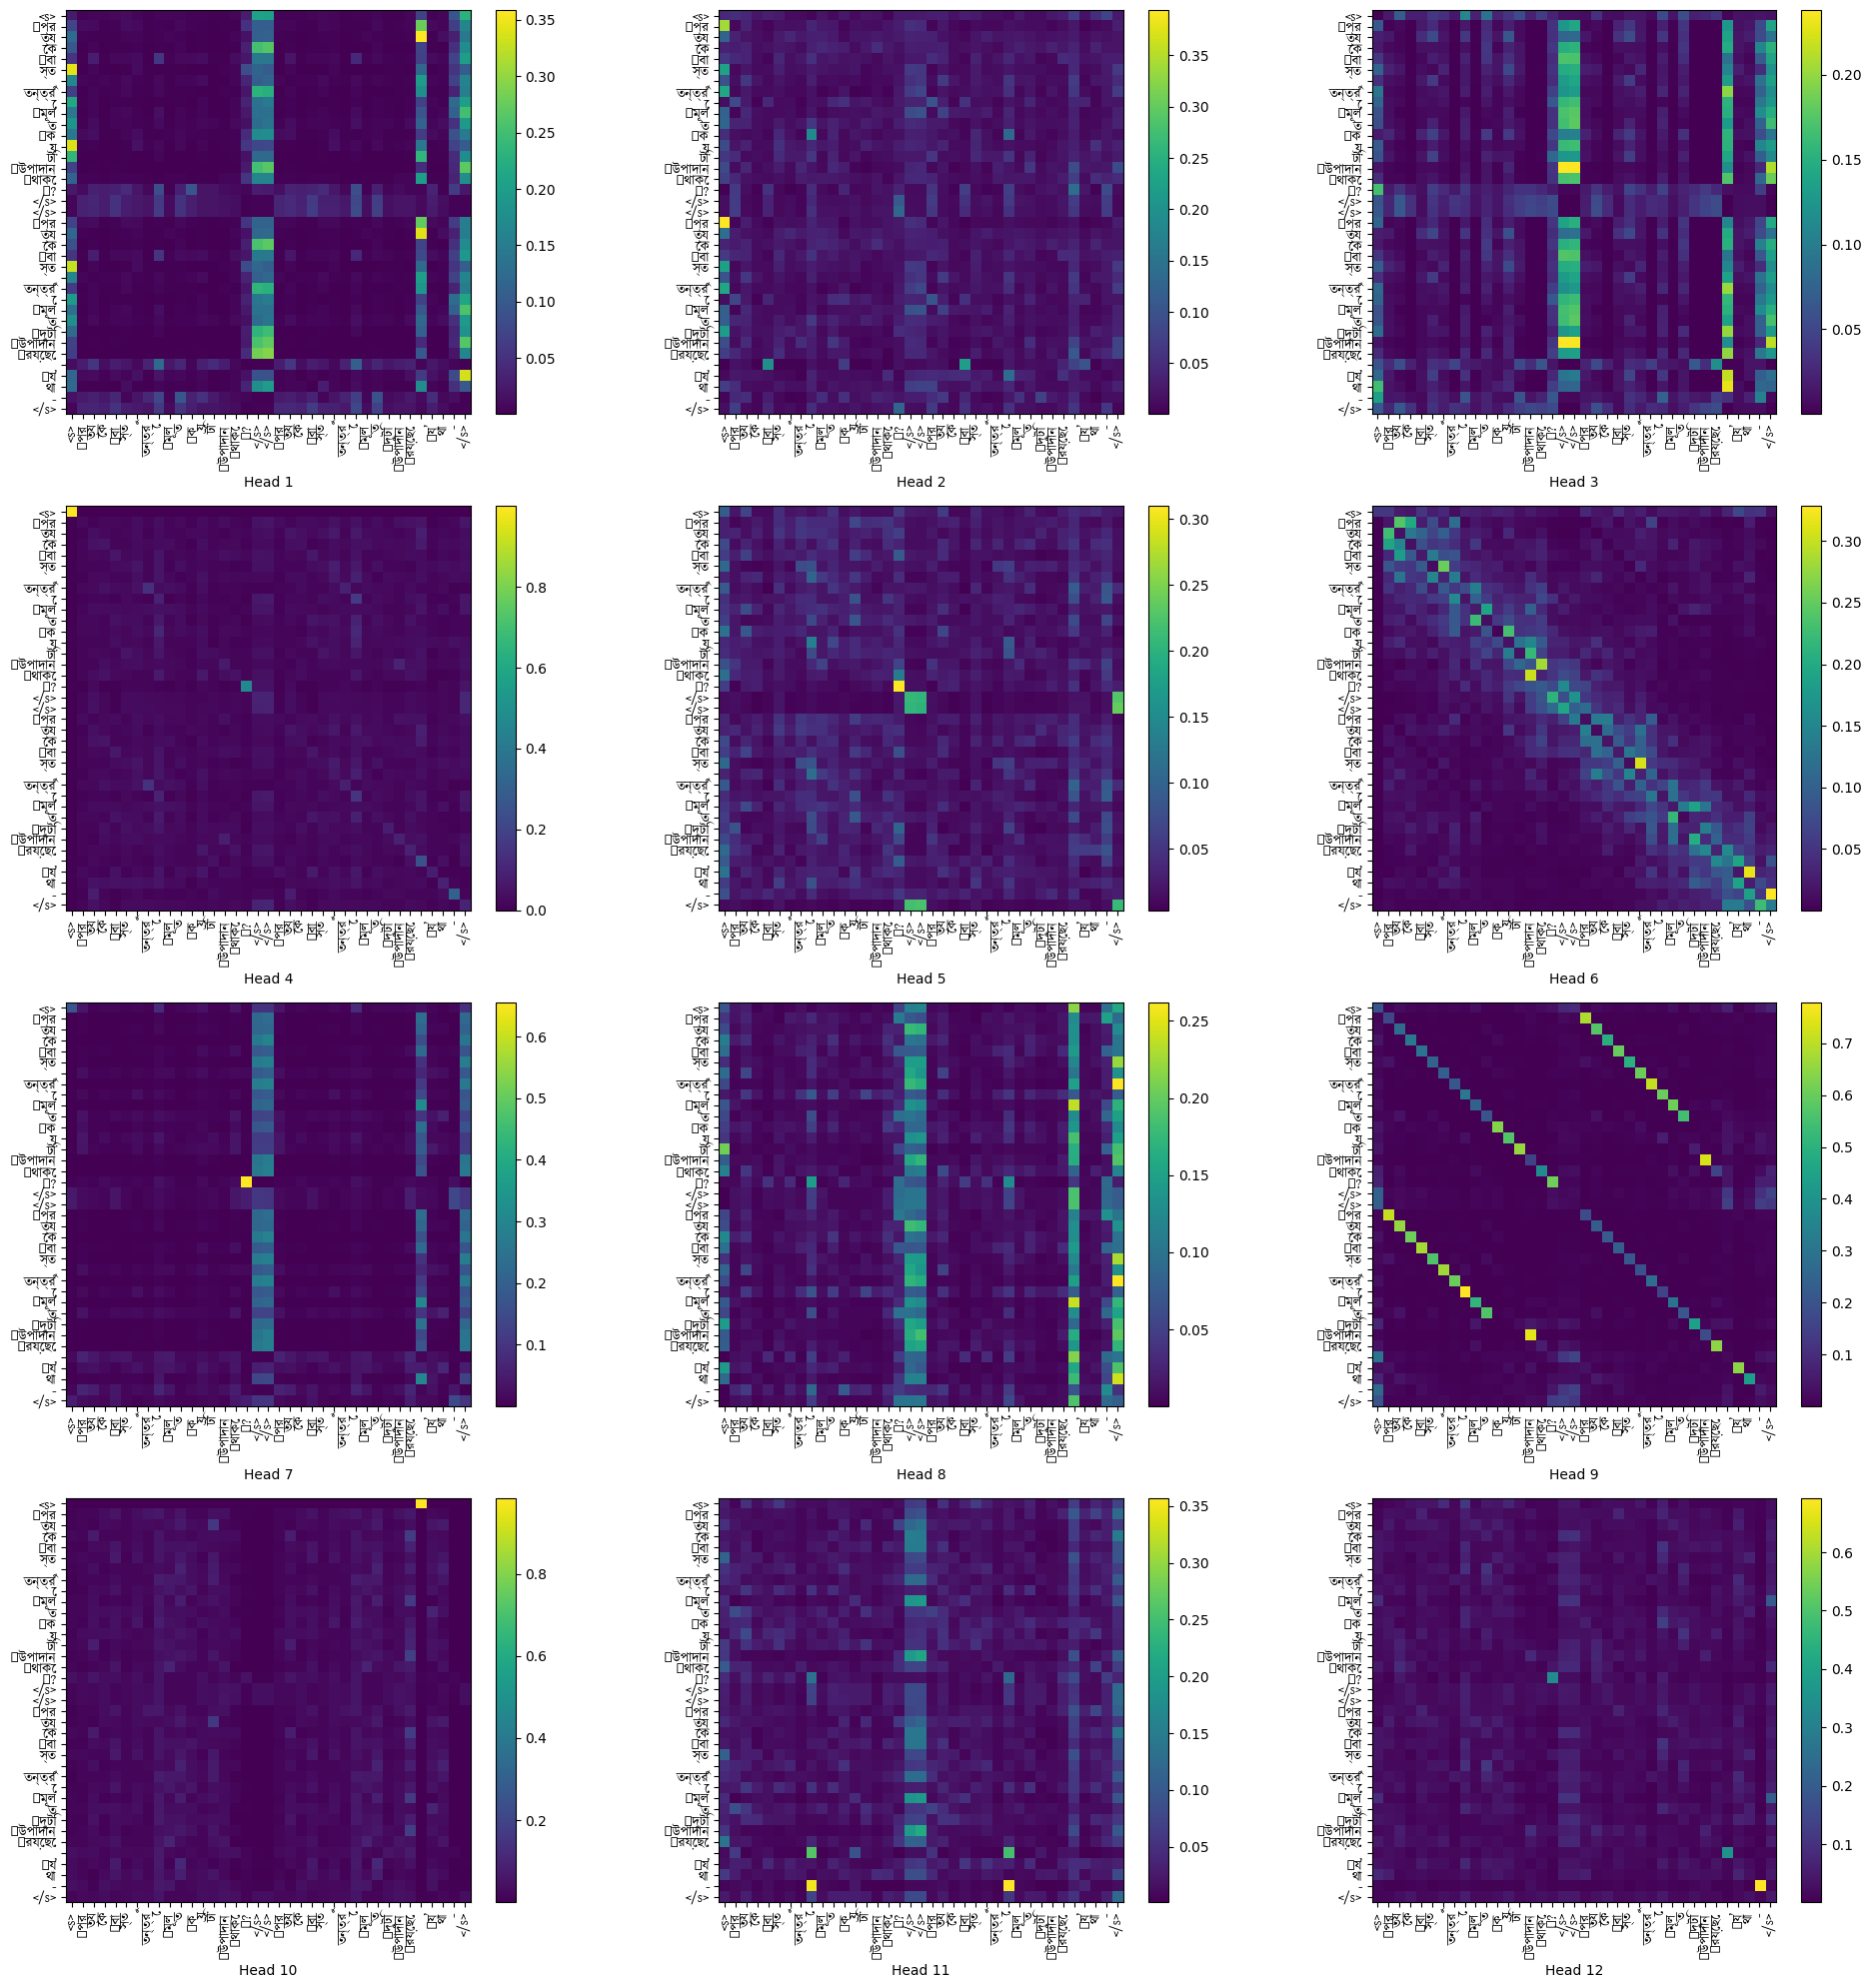

In [57]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

prop = fm.FontProperties(fname='kalpurush.ttf')

visualize_token2token_scores(output_attentions_all[0].squeeze().detach().cpu().numpy(), tokens, fontproperties=prop)

## Arabic

In [58]:
from transformers import AutoModel

MODEL_NAME = "simoneZethof/Arabic_multi"

model = AutoModel.from_pretrained(MODEL_NAME, output_attentions=True)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

(…)of/Arabic_multi/resolve/main/config.json:   0%|          | 0.00/716 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Some weights of XLMRobertaModel were not initialized from the model checkpoint at simoneZethof/Arabic_multi and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(…)multi/resolve/main/tokenizer_config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

(…)lti/resolve/main/special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

In [59]:
row = get_min_text(val_arabic_answerble)

ds_val = val_arabic_answerble.filter(lambda x: x['id'] == row['id'])

validation_dataset = ds_val.map(partial(get_validation_features, tokenizer), batched=True, remove_columns=ds_val.column_names)
val_dl = DataLoader(validation_dataset, collate_fn=val_collate_fn, batch_size=32)

Filter:   0%|          | 0/951 [00:00<?, ? examples/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

In [60]:
for batch in val_dl:
  outputs = model(
      input_ids=batch['input_ids'],
      attention_mask=batch['attention_mask']
  )

  input_ids = batch["input_ids"]
  tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
  attention = outputs["attentions"]
  output_attentions_all = torch.stack(attention)

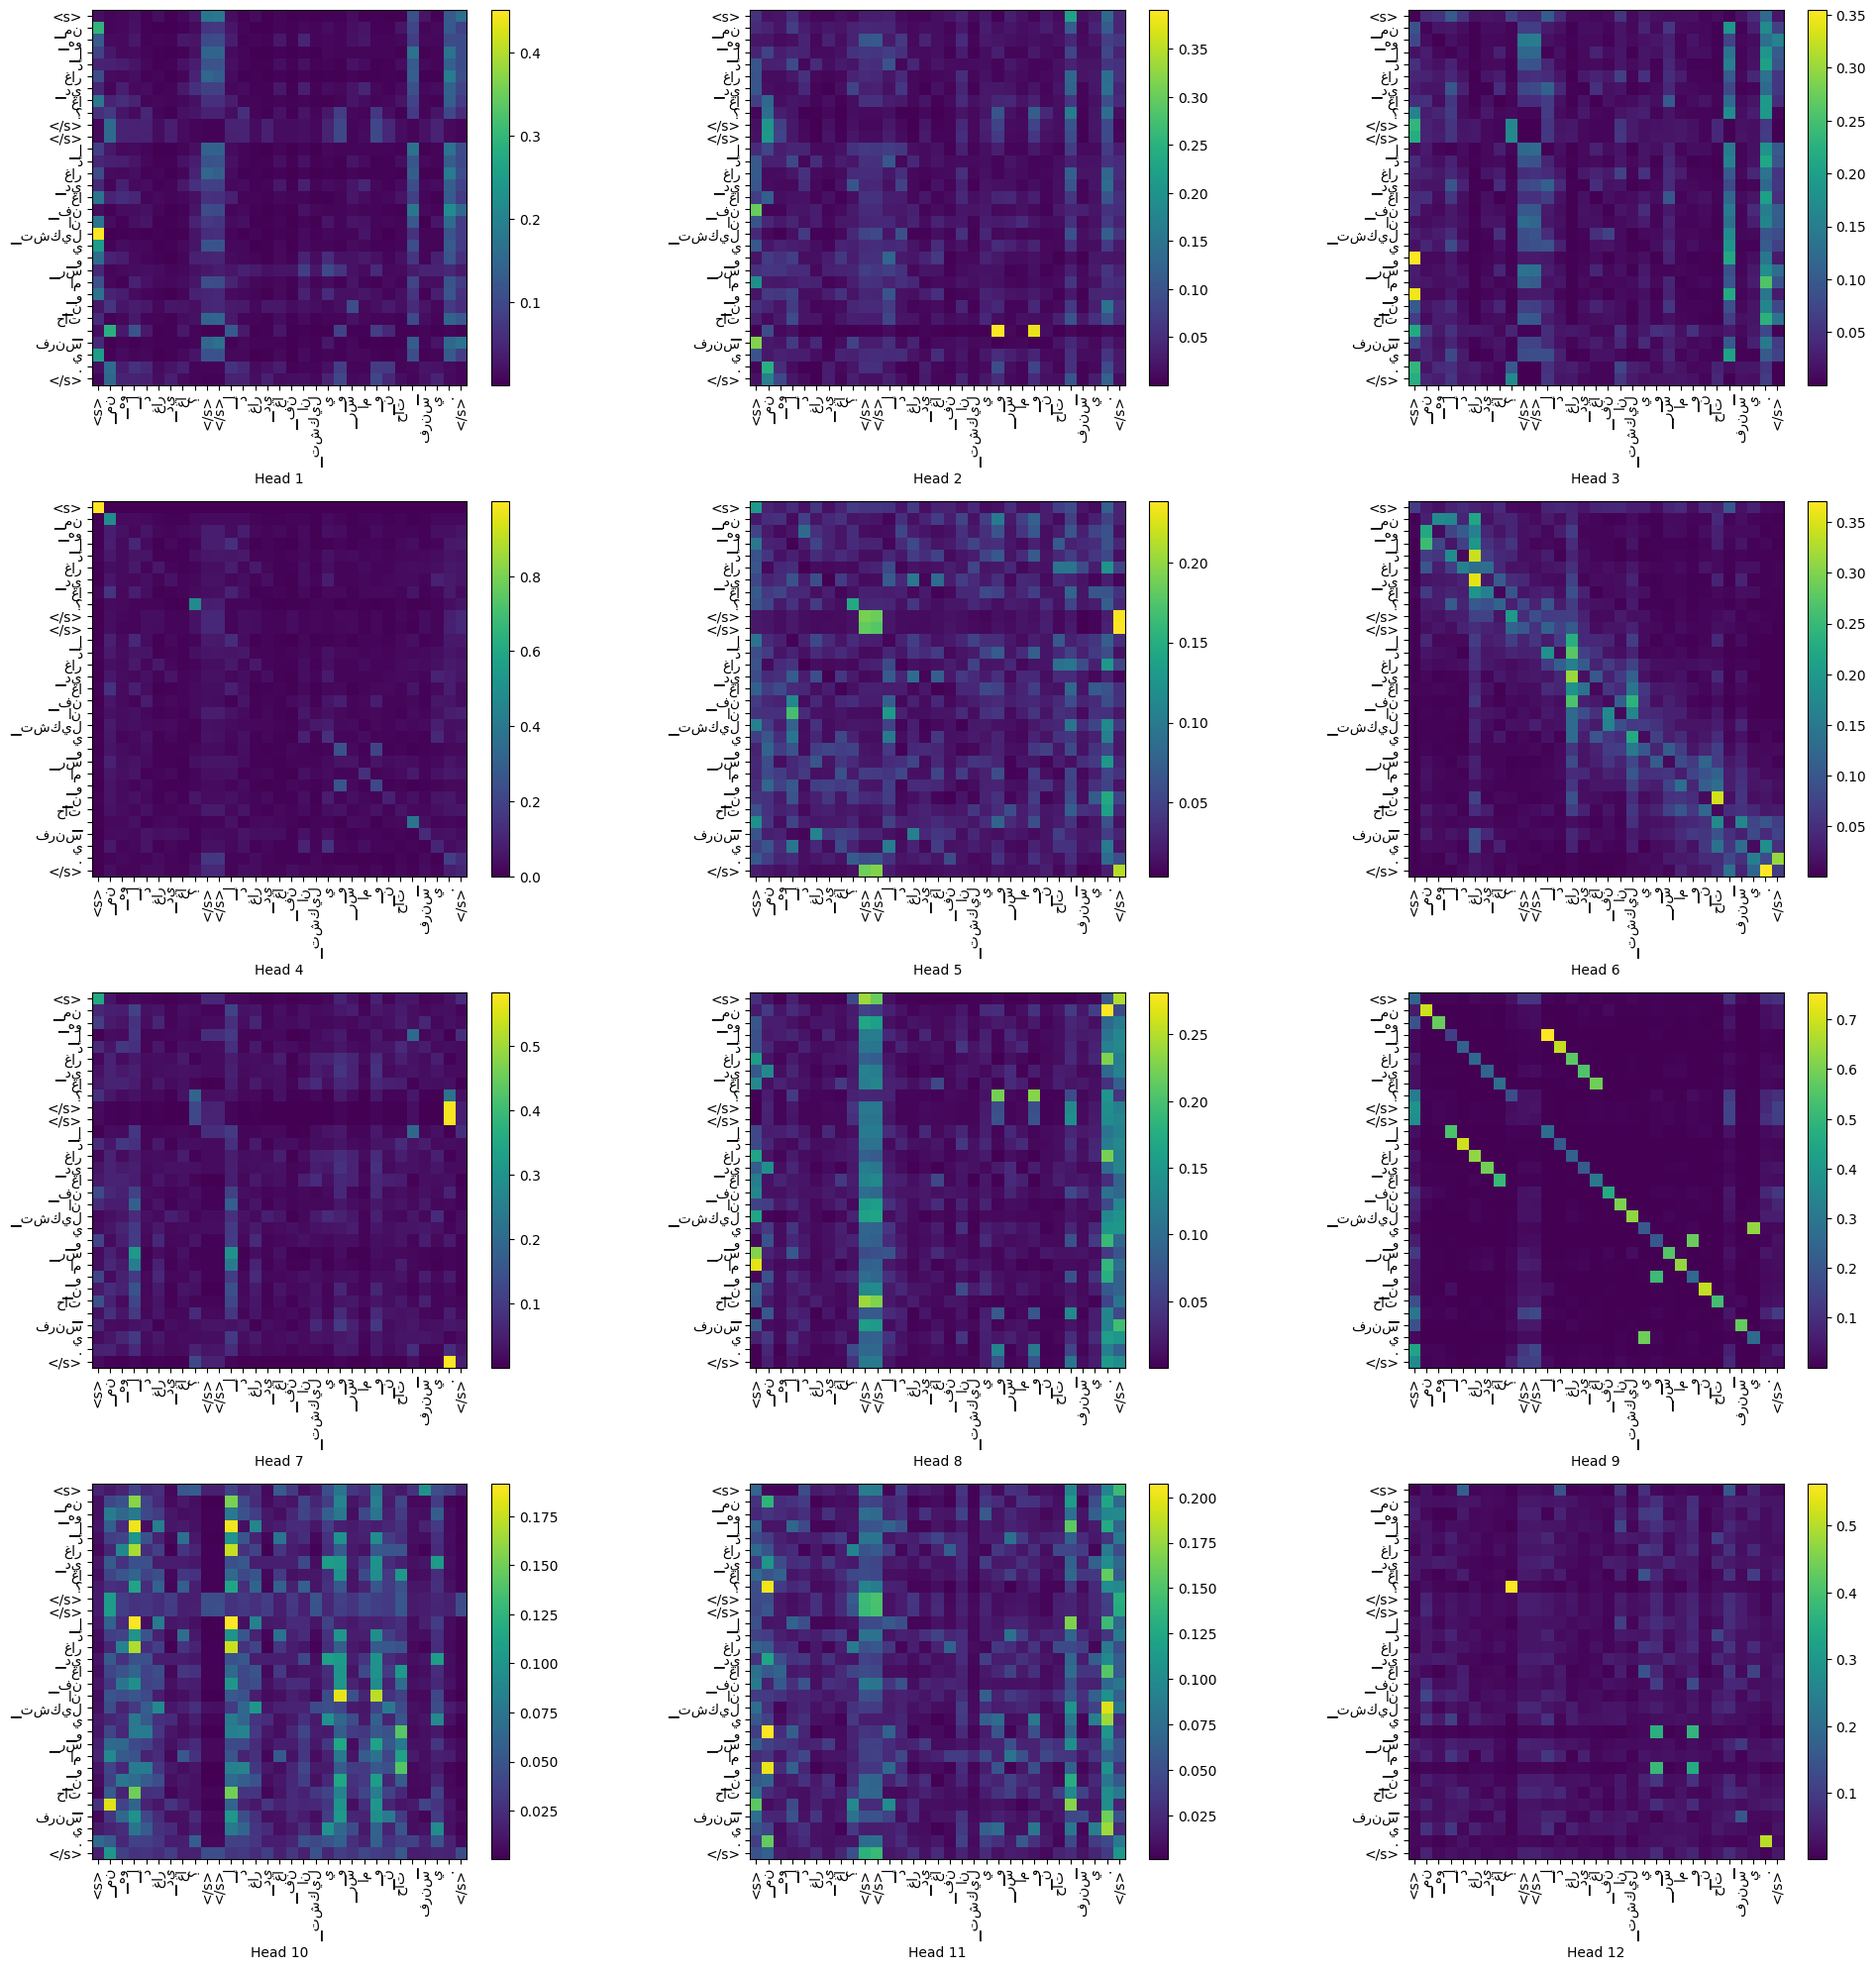

In [61]:
visualize_token2token_scores(output_attentions_all[0].squeeze().detach().cpu().numpy(), tokens)

## Indonesian

In [51]:
from transformers import AutoModel

MODEL_NAME = "simoneZethof/Indonesian_multi"

model = AutoModel.from_pretrained(MODEL_NAME, output_attentions=True)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

Some weights of XLMRobertaModel were not initialized from the model checkpoint at simoneZethof/Indonesian_multi and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [35]:
row = get_min_text(val_indonesian_answerble)

ds_val = val_indonesian_answerble.filter(lambda x: x['id'] == row['id'])

validation_dataset = ds_val.map(partial(get_validation_features, tokenizer), batched=True, remove_columns=ds_val.column_names)
val_dl = DataLoader(validation_dataset, collate_fn=val_collate_fn, batch_size=32)

In [50]:
len(row)

{'question_text': 'Apa nama badan PBB yang mengurus tentang perlindungan anak ?',
 'document_title': 'Dewan Ekonomi dan Sosial Perserikatan Bangsa-Bangsa',
 'language': 'indonesian',
 'annotations': {'answer_start': [2], 'answer_text': ['UNICEF']},
 'document_plaintext': '•\tUNICEF (United Nations Children Fund)',
 'document_url': 'https://id.wikipedia.org/wiki/Dewan%20Ekonomi%20dan%20Sosial%20Perserikatan%20Bangsa-Bangsa',
 'id': 2036}

In [46]:
for batch in val_dl:
  outputs = model(
      input_ids=batch['input_ids'],
      attention_mask=batch['attention_mask']
  )

  input_ids = batch["input_ids"]
  tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
  attention = outputs["attentions"]
  output_attentions_all = torch.stack(attention)

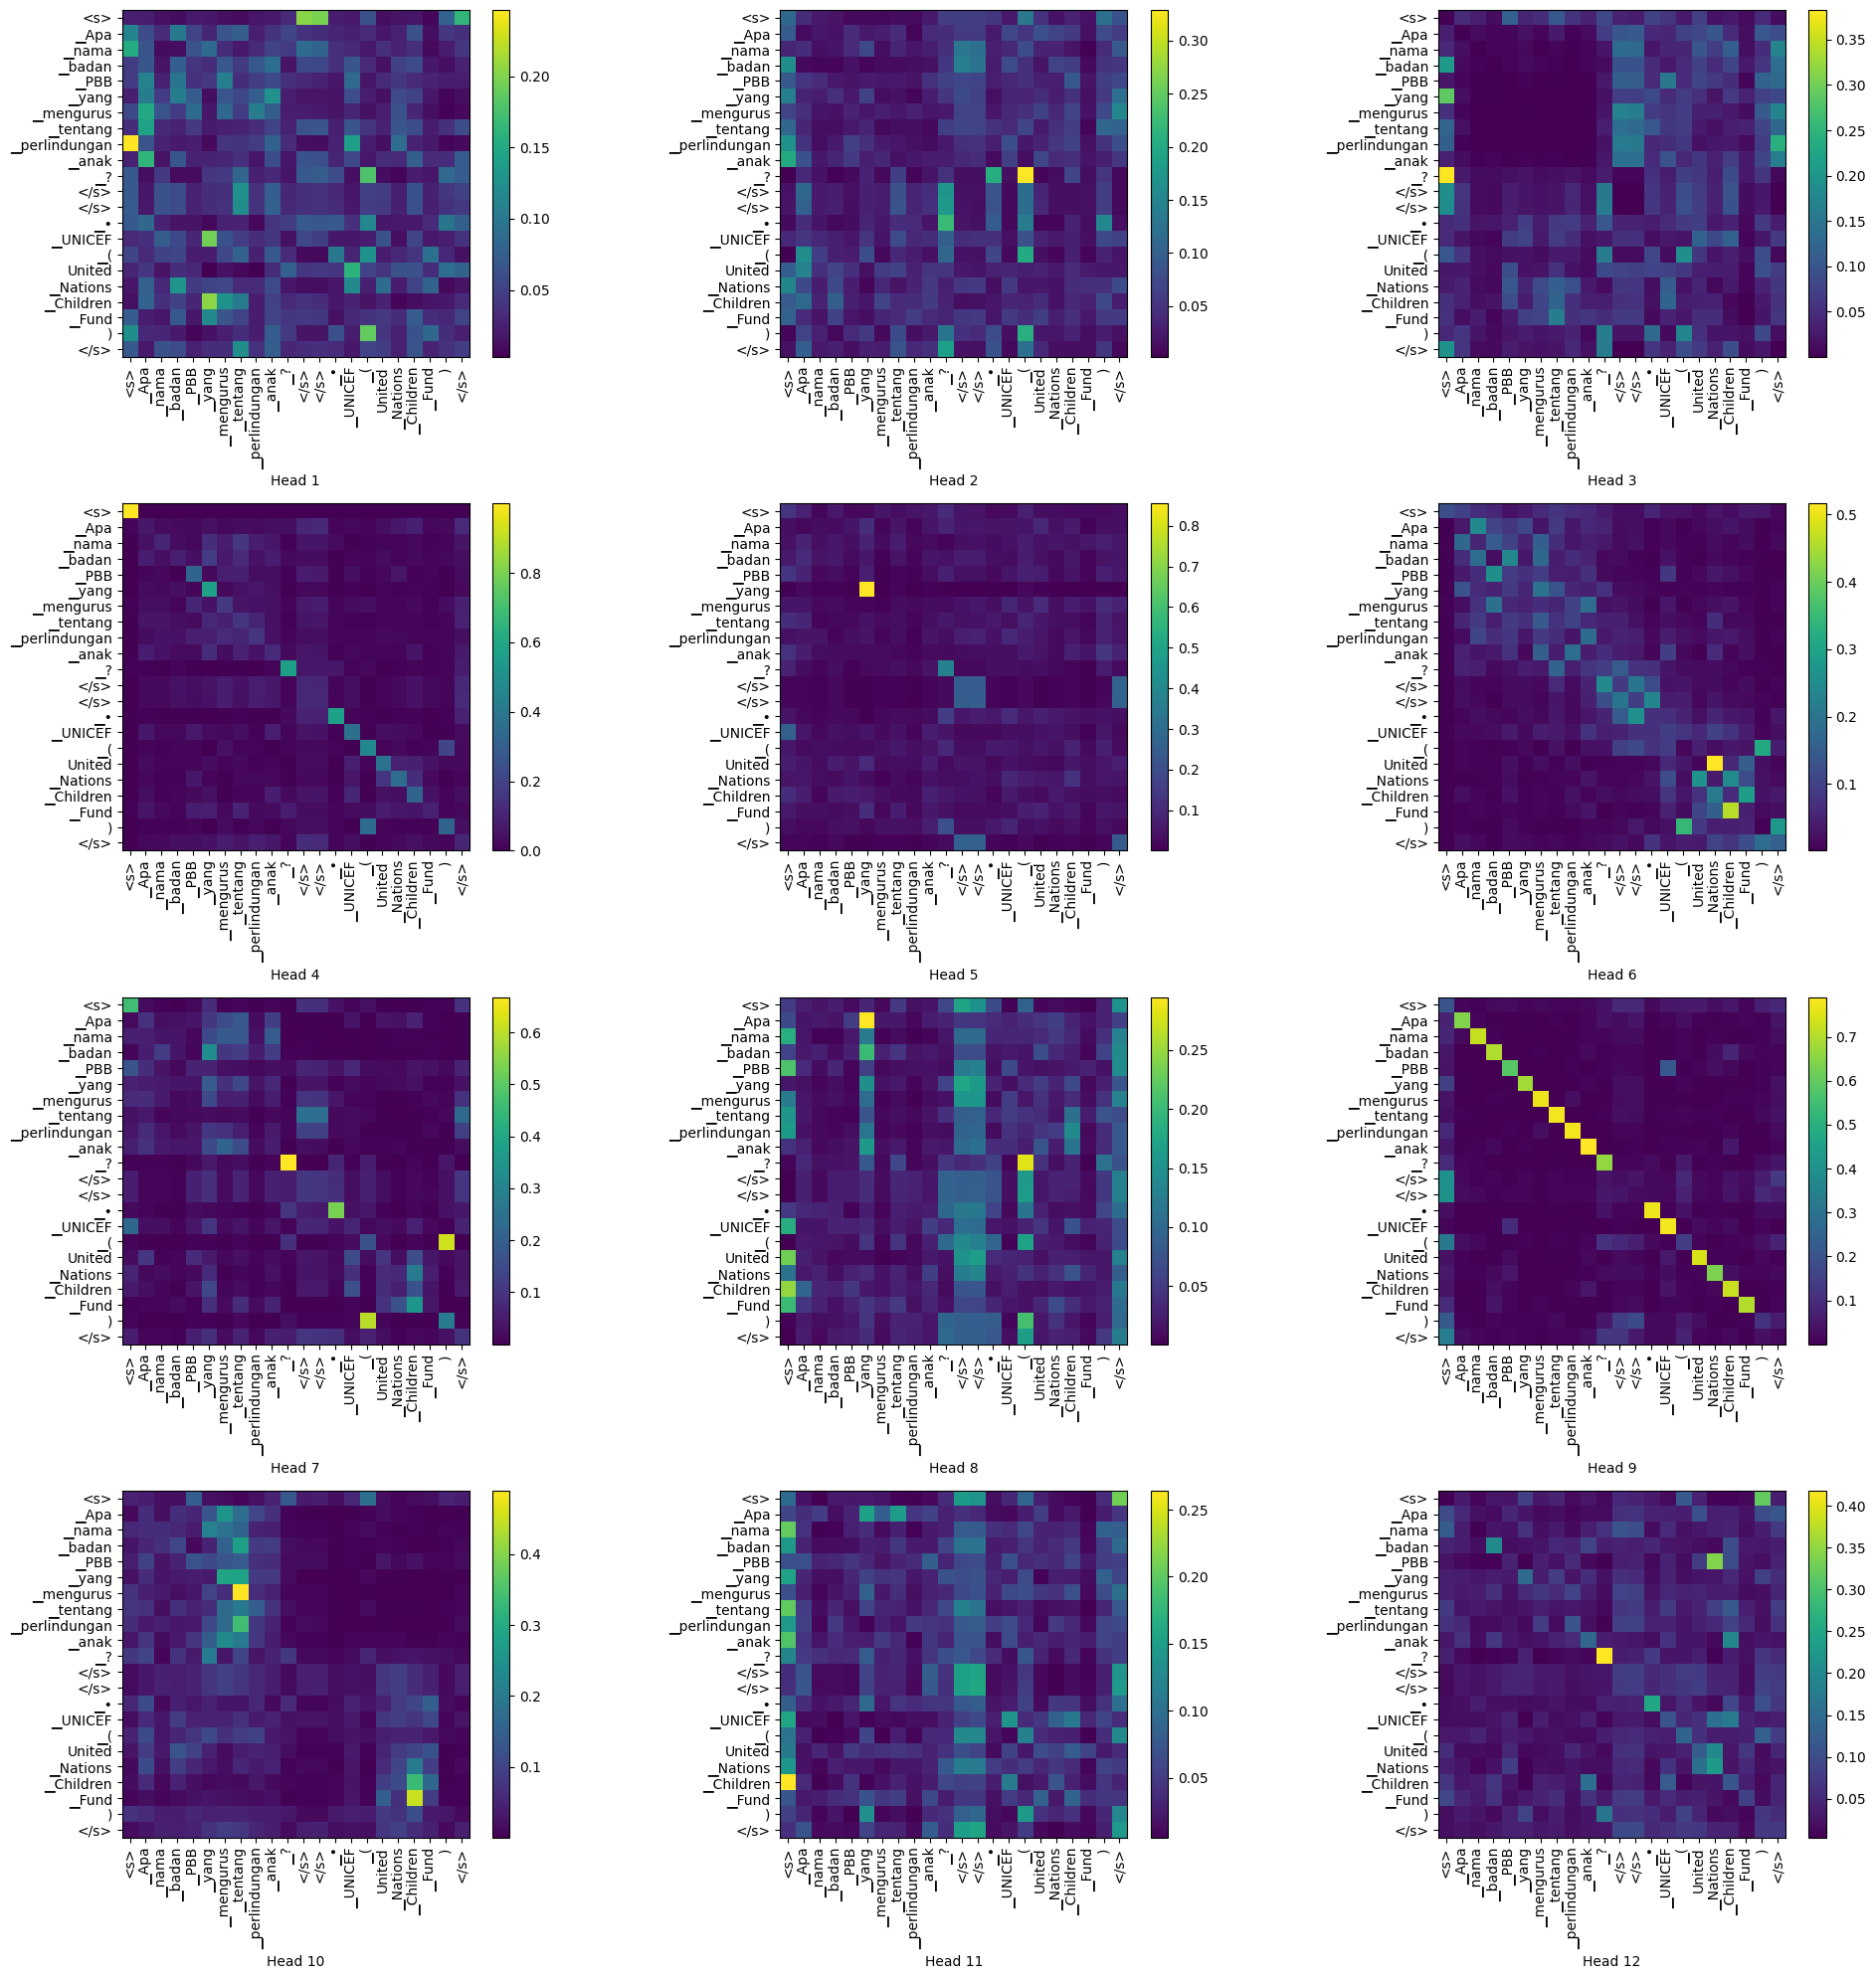

In [49]:
visualize_token2token_scores(output_attentions_all[0].squeeze().detach().cpu().numpy(), tokens)